# Data pre-processing and pre-analysis
This will be a script for doing some of the initial pre-processing and analysis.

Script stages:

1) Initial stuff and functions for loading in the data and resizing etc.

2) Constructing the model

3)

4)

In [30]:
# Importing libraries
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Defining paths
train_path = '../../../Desktop/kaggle/cats_dogs/train/' # Locating of dog files
test_path = '../../../Desktop/kaggle/cats_dogs/test1/' # Location of cat files
pickle_path = '../../../Desktop/kaggle/cats_dogs/' # Location where saving pickles

# Defining constants
NUM_TRAINING = 1000
NUM_TEST = 100
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNELS = 3
SAMPLE_SIZE = 250 # How many samples we take for the experiments (note will take even of each)

Will treat the data by their file links - I think this is easier for the time being as it stops having to lug around huge images

In [3]:
# Get the image files
train_files = [train_path + file_name for file_name in os.listdir(train_path)]
test_files = [test_path + file_name for file_name in os.listdir(test_path)]

dog_files = [file_name for file_name in train_files if 'train/dog' in file_name]
cat_files = [file_name for file_name in train_files if 'train/cat' in file_name]

print dog_files[0:5]
print cat_files[0:5]
print 'There are {} dog files'.format(len(dog_files))
print 'There are {} cat files'.format(len(cat_files))

['../../../Desktop/kaggle/cats_dogs/train/dog.0.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.1.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.10.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.100.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.1000.jpg']
['../../../Desktop/kaggle/cats_dogs/train/cat.0.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.1.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.10.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.100.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.1000.jpg']
There are 12500 dog files
There are 12500 cat files


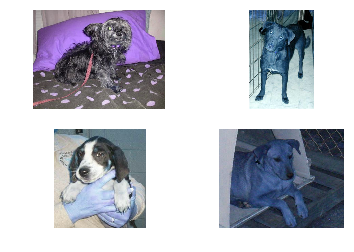

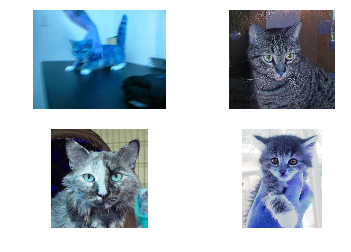

In [13]:
def panel_graph(image_files):
    images = [cv2.imread(image_file, cv2.IMREAD_COLOR) for image_file in image_files[0:4]]
    images = np.reshape(images, (2,2))
    _, ax = plt.subplots(2,2)
    for i in range(2):
        for j in range(2):
            ax[i,j].imshow(images[i, j])
            ax[i,j].axis('off')
    plt.show()

# Displaying some images
panel_graph(dog_files)
panel_graph(cat_files)

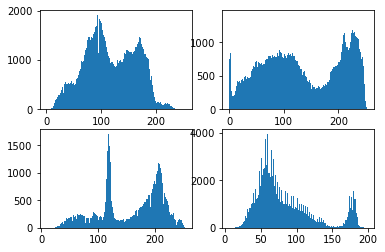

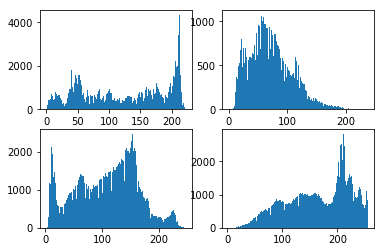

In [5]:
def panel_hist(image_files):
    images = [cv2.imread(image_file, cv2.IMREAD_COLOR).mean(axis=2).flatten() for image_file in image_files[0:4]]
    images = np.reshape(images, (2,2))
    _, ax = plt.subplots(2,2)
    for i in range(2):
        for j in range(2):
            ax[i,j].hist(images[i, j], 255)
            
    plt.show()

# Histograms of pixel values
panel_hist(dog_files)
panel_hist(cat_files)

Once looked at some of the raw data, will transform it and re-graph to see how stuff changes. Transformations to be made are

* Resize

* Histogram equalisation

* Mean image

In [34]:
# Data preparation
def data_read(image_path):
    '''
    Function to read in the data and do some of the basic transformations
    Note that it will take a single path and transform - everything is for one image
    '''
    # Load
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Histogram
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    # Resize
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_CUBIC)

def data_norm(train, test = None):
    '''
    Function to get normalise - NOT sure about axes on this one
    Note that it will return first the data, then the mean and std
    From tests it definitely gets it normalised
    '''
    # Assuming we have a data frame of all pictures
    data_mean = train.mean(axis = 0)
    data_std = train.std(axis = 0)
    
    train -= data_mean
    train /= data_std
    if test:
        test -= data_mean
        test /= data_std
        return train, test, data_mean, data_std
    else:
        return train, data_mean, data_std

def data_prep(image_files, read = False):
    '''
    Here we will try to combine all the files into a frame after processing them a bit
    '''
    if read:
        print 'Loading dataset from file'
        with open(pickle_path + 'all_image_data.pickle', 'rb') as pickle_file:
            all_data = pickle.load(pickle_file)
        
    else:
        print 'Loading images directly from file'
        num_files = len(image_files)
        all_data = np.ndarray((num_files, CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

        for i, image_file in enumerate(image_files):
            image = data_read(image_file)
            # Axes are height, width, colour .T will flip the first and last axes
            all_data[i] = image.T
            if i % 100 == 0:
                print 'Loaded {} from {} files'.format(i, num_files)
        with open(pickle_path + 'all_image_data.pickle', 'wb') as pickle_file:
            print 'Writing dataset to file'
            pickle.dump(all_data, pickle_file)
        
    print 'Final shape {}'.format(all_data.shape)
    return all_data
    

# Visualising the processed images
Now will just compare some of the images to see how it works. Not expecting them to necessarily "look" better, but to work better with a learning algorithm

(412L, 263L, 3L)
(256L, 256L, 3L)


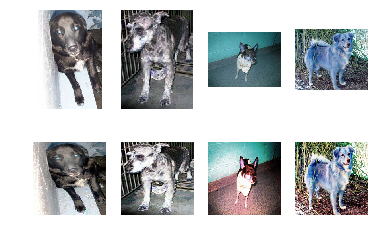

(359L, 431L, 3L)
(256L, 256L, 3L)


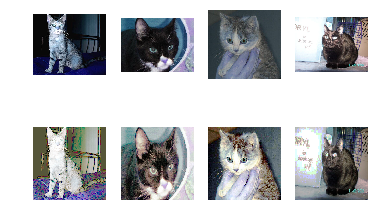

In [22]:
def image_compare(image_files, start = 0, end = 4):
    images_before = [cv2.imread(image_file, cv2.IMREAD_COLOR) for image_file in image_files[start:end]]
    images_after = [data_read(image_file) for image_file in image_files[start:end]]    
    
    if start != end:
        size = end - start
    else:
        size = 1
        
    _, ax = plt.subplots(2, size)
    for i in range(size):
        ax[0,i].imshow(images_before[i])
        ax[1,i].imshow(images_after[i])
        ax[0,i].axis('off')
        ax[1,i].axis('off')
    plt.show()

# Displaying some images
image_compare(dog_files, start = 5, end = 9)
image_compare(cat_files, start = 5, end = 9)

Plotting Histograms as here should be more difference - from OpenCV

"Consider an image whose pixel values are confined to some specific range of values only. For eg, brighter image will have all pixels confined to high values. But a good image will have pixels from all regions of the image. So you need to stretch this histogram to either ends (as given in below image, from wikipedia) and that is what Histogram Equalization does (in simple words). This normally improves the contrast of the image."

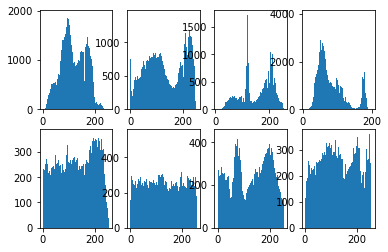

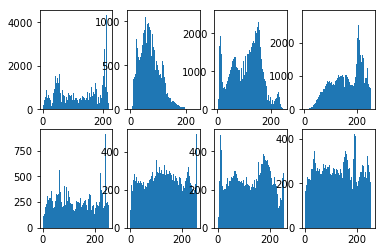

In [24]:
def hist_compare(image_files, start = 0, end = 4):
    images_before = [cv2.imread(image_file, cv2.IMREAD_COLOR).mean(axis=2).flatten() for image_file in image_files[start:end]]
    images_after = [data_read(image_file).mean(axis=2).flatten() for image_file in image_files[start:end]]    
    
    if start != end:
        size = end - start
    else:
        size = 1
        
    _, ax = plt.subplots(2, size)
    for i in range(size):
        ax[0,i].hist(images_before[i], 255)
        ax[1,i].hist(images_after[i], 255)
    plt.show()

# Displaying the histograms
hist_compare(dog_files)
hist_compare(cat_files)

Now will look at the whole data set and see how things look after normalisation - note that will only take the sample sized defined to investigate

In [35]:
data_raw = data_prep(dog_files[0:SAMPLE_SIZE] + cat_files[0:SAMPLE_SIZE])
data_norm, data_mean, data_std = data_norm(data_raw)

Loading images directly from file
Loaded 0 from 500 files
Loaded 100 from 500 files
Loaded 200 from 500 files
Loaded 300 from 500 files
Loaded 400 from 500 files
Writing dataset to file
Final shape (500L, 3L, 256L, 256L)


(256L, 256L, 3L, 500L)
(256L, 256L, 3L)


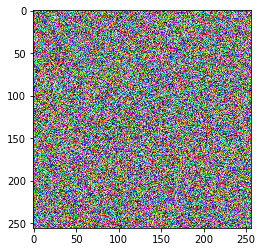

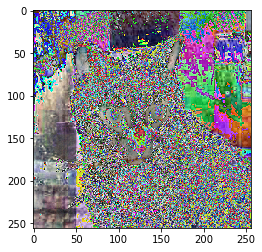

In [44]:
print data_norm.T.shape
print data_mean.T.shape

plt.imshow(data_mean.T)
plt.show()

plt.imshow(data_norm[251].T)
plt.show()

# Constructing the model
After preprocessing stuff will start to actually construct the model to be used